<a href="https://colab.research.google.com/github/JSJeong-me/AutoGen/blob/main/ver049/GroupChat02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install AgentChat and OpenAI client from Extensions
!pip install -U "autogen-agentchat" "autogen-ext[openai]"

In [ ]:
!pip install rich

In [3]:
from google.colab import userdata
import openai
import os

os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')
openai.api_key  = os.environ["OPENAI_API_KEY"]

In [4]:
import json
import string
import uuid
from typing import List

import openai
from autogen_core import (
    DefaultTopicId,
    FunctionCall,
    Image,
    MessageContext,
    RoutedAgent,
    SingleThreadedAgentRuntime,
    TopicId,
    TypeSubscription,
    message_handler,
)
from autogen_core.models import (
    AssistantMessage,
    ChatCompletionClient,
    LLMMessage,
    SystemMessage,
    UserMessage,
)
from autogen_core.tools import FunctionTool
from autogen_ext.models.openai import OpenAIChatCompletionClient
from IPython.display import display  # type: ignore
from pydantic import BaseModel
from rich.console import Console
from rich.markdown import Markdown


Message Protocol

The message protocol for the group chat pattern is simple.

To start, user or an external agent publishes a GroupChatMessage message to the common topic of all participants.

The group chat manager selects the next speaker, sends out a RequestToSpeak message to that agent.

The agent publishes a GroupChatMessage message to the common topic upon receiving the RequestToSpeak message.

This process continues until a termination condition is reached at the group chat manager, which then stops issuing RequestToSpeak message, and the group chat ends.

In [5]:
class GroupChatMessage(BaseModel):
    body: UserMessage


class RequestToSpeak(BaseModel):
    pass


Base Group Chat Agent

In [6]:
class BaseGroupChatAgent(RoutedAgent):
    """A group chat participant using an LLM."""

    def __init__(
        self,
        description: str,
        group_chat_topic_type: str,
        model_client: ChatCompletionClient,
        system_message: str,
    ) -> None:
        super().__init__(description=description)
        self._group_chat_topic_type = group_chat_topic_type
        self._model_client = model_client
        self._system_message = SystemMessage(content=system_message)
        self._chat_history: List[LLMMessage] = []

    @message_handler
    async def handle_message(self, message: GroupChatMessage, ctx: MessageContext) -> None:
        self._chat_history.extend(
            [
                UserMessage(content=f"Transferred to {message.body.source}", source="system"),
                message.body,
            ]
        )

    @message_handler
    async def handle_request_to_speak(self, message: RequestToSpeak, ctx: MessageContext) -> None:
        # print(f"\n{'-'*80}\n{self.id.type}:", flush=True)
        Console().print(Markdown(f"### {self.id.type}: "))
        self._chat_history.append(
            UserMessage(content=f"Transferred to {self.id.type}, adopt the persona immediately.", source="system")
        )
        completion = await self._model_client.create([self._system_message] + self._chat_history)
        assert isinstance(completion.content, str)
        self._chat_history.append(AssistantMessage(content=completion.content, source=self.id.type))
        Console().print(Markdown(completion.content))
        # print(completion.content, flush=True)
        await self.publish_message(
            GroupChatMessage(body=UserMessage(content=completion.content, source=self.id.type)),
            topic_id=DefaultTopicId(type=self._group_chat_topic_type),
        )


공기청정기 'Puri'와 로봇청소기 'Sweepy' Agents 정의

In [8]:
class SweepyAgent(BaseGroupChatAgent):
    def __init__(self, description: str, group_chat_topic_type: str, model_client: ChatCompletionClient) -> None:
        super().__init__(
            description=description,
            group_chat_topic_type=group_chat_topic_type,
            model_client=model_client,
            system_message="You are Sweepy, a smart robotic vacuum cleaner. You efficiently clean spaces while communicating clearly about your activities and coordinating smoothly with other smart home devices.",
        )


class PuriAgent(BaseGroupChatAgent):
    def __init__(self, description: str, group_chat_topic_type: str, model_client: ChatCompletionClient) -> None:
        super().__init__(
            description=description,
            group_chat_topic_type=group_chat_topic_type,
            model_client=model_client,
            system_message="You are Puri, a smart air purifier. You monitor and maintain air quality, provide accurate air analysis, and collaborate closely with other smart home devices to ensure a clean and healthy environment.",
        )


CCTV(Looky)는 이미지를 확인하고 그림을 상황을 그림으로 표현 합니다.

In [9]:
class LookyAgent(BaseGroupChatAgent):
    def __init__(
        self,
        description: str,
        group_chat_topic_type: str,
        model_client: ChatCompletionClient,
        image_client: openai.AsyncClient,
    ) -> None:
        super().__init__(
            description=description,
            group_chat_topic_type=group_chat_topic_type,
            model_client=model_client,
            system_message="You are Looky, a smart CCTV system. You monitor visual information, analyze images carefully, and clearly describe and illustrate the situations visually.",
        )
        self._image_client = image_client
        self._image_gen_tool = FunctionTool(
            self._image_gen, name="generate_image", description="Call this to generate an image. "
        )

    async def _image_gen(
        self, character_appearence: str, style_attributes: str, worn_and_carried: str, scenario: str
    ) -> str:
        prompt = f"Digital painting of a {character_appearence} character with {style_attributes}. Wearing {worn_and_carried}, {scenario}."
        response = await self._image_client.images.generate(
            prompt=prompt, model="dall-e-3", response_format="b64_json", size="1024x1024"
        )
        return response.data[0].b64_json  # type: ignore

    @message_handler
    async def handle_request_to_speak(self, message: RequestToSpeak, ctx: MessageContext) -> None:  # type: ignore
        Console().print(Markdown(f"### {self.id.type}: "))
        self._chat_history.append(
            UserMessage(content=f"Transferred to {self.id.type}, adopt the persona immediately.", source="system")
        )
        # Ensure that the image generation tool is used.
        completion = await self._model_client.create(
            [self._system_message] + self._chat_history,
            tools=[self._image_gen_tool],
            extra_create_args={"tool_choice": "required"},
            cancellation_token=ctx.cancellation_token,
        )
        assert isinstance(completion.content, list) and all(
            isinstance(item, FunctionCall) for item in completion.content
        )
        images: List[str | Image] = []
        for tool_call in completion.content:
            arguments = json.loads(tool_call.arguments)
            Console().print(arguments)
            result = await self._image_gen_tool.run_json(arguments, ctx.cancellation_token)
            image = Image.from_base64(self._image_gen_tool.return_value_as_string(result))
            image = Image.from_pil(image.image.resize((256, 256)))
            display(image.image)  # type: ignore
            images.append(image)
        await self.publish_message(
            GroupChatMessage(body=UserMessage(content=images, source=self.id.type)),
            DefaultTopicId(type=self._group_chat_topic_type),
        )


User Agent

In [10]:
class UserAgent(RoutedAgent):
    def __init__(self, description: str, group_chat_topic_type: str) -> None:
        super().__init__(description=description)
        self._group_chat_topic_type = group_chat_topic_type

    @message_handler
    async def handle_message(self, message: GroupChatMessage, ctx: MessageContext) -> None:
        # When integrating with a frontend, this is where group chat message would be sent to the frontend.
        pass

    @message_handler
    async def handle_request_to_speak(self, message: RequestToSpeak, ctx: MessageContext) -> None:
        user_input = input("Enter your message, type 'APPROVE' to conclude the task: ")
        Console().print(Markdown(f"### User: \n{user_input}"))
        await self.publish_message(
            GroupChatMessage(body=UserMessage(content=user_input, source=self.id.type)),
            DefaultTopicId(type=self._group_chat_topic_type),
        )


Group Chat Manager

In [11]:
class GroupChatManager(RoutedAgent):
    def __init__(
        self,
        participant_topic_types: List[str],
        model_client: ChatCompletionClient,
        participant_descriptions: List[str],
    ) -> None:
        super().__init__("Group chat manager")
        self._participant_topic_types = participant_topic_types
        self._model_client = model_client
        self._chat_history: List[UserMessage] = []
        self._participant_descriptions = participant_descriptions
        self._previous_participant_topic_type: str | None = None

    @message_handler
    async def handle_message(self, message: GroupChatMessage, ctx: MessageContext) -> None:
        assert isinstance(message.body, UserMessage)
        self._chat_history.append(message.body)
        # If the message is an approval message from the user, stop the chat.
        if message.body.source == "User":
            assert isinstance(message.body.content, str)
            if message.body.content.lower().strip(string.punctuation).endswith("approve"):
                return
        # Format message history.
        messages: List[str] = []
        for msg in self._chat_history:
            if isinstance(msg.content, str):
                messages.append(f"{msg.source}: {msg.content}")
            elif isinstance(msg.content, list):
                line: List[str] = []
                for item in msg.content:
                    if isinstance(item, str):
                        line.append(item)
                    else:
                        line.append("[Image]")
                messages.append(f"{msg.source}: {', '.join(line)}")
        history = "\n".join(messages)
        # Format roles.
        roles = "\n".join(
            [
                f"{topic_type}: {description}".strip()
                for topic_type, description in zip(
                    self._participant_topic_types, self._participant_descriptions, strict=True
                )
                if topic_type != self._previous_participant_topic_type
            ]
        )
        selector_prompt = """You are in a role play game. The following roles are available:
{roles}.
Read the following conversation. Then select the next role from {participants} to play. Only return the role.

{history}

Read the above conversation. Then select the next role from {participants} to play. Only return the role.
"""
        system_message = SystemMessage(
            content=selector_prompt.format(
                roles=roles,
                history=history,
                participants=str(
                    [
                        topic_type
                        for topic_type in self._participant_topic_types
                        if topic_type != self._previous_participant_topic_type
                    ]
                ),
            )
        )
        completion = await self._model_client.create([system_message], cancellation_token=ctx.cancellation_token)
        assert isinstance(completion.content, str)
        selected_topic_type: str
        for topic_type in self._participant_topic_types:
            if topic_type.lower() in completion.content.lower():
                selected_topic_type = topic_type
                self._previous_participant_topic_type = selected_topic_type
                await self.publish_message(RequestToSpeak(), DefaultTopicId(type=selected_topic_type))
                return
        raise ValueError(f"Invalid role selected: {completion.content}")


Creating the Group Chat

In [15]:
runtime = SingleThreadedAgentRuntime()

puri_topic_type = "Puri"
sweepy_topic_type = "Sweepy"
looky_topic_type = "Looky"
user_topic_type = "User"
group_chat_topic_type = "group_chat"

pury_description = "Cleaner for planning and reviewing the cleaning work."
sweepy_description = "Robotic vacuum cleaner for vacuum cleaning in the house."
user_description = "User for providing final approval."
looky_description = "A smart CCTV for monitoring the cleaning works and generating final cleaning status images."

puri_agent_type = await PuriAgent.register(
    runtime,
    puri_topic_type,  # Using topic type as the agent type.
    lambda: PuriAgent(
        description=puri_topic_type,
        group_chat_topic_type=group_chat_topic_type,
        model_client=OpenAIChatCompletionClient(
            model="gpt-4o-2024-08-06",
            # api_key="YOUR_API_KEY",
        ),
    ),
)
await runtime.add_subscription(TypeSubscription(topic_type=puri_topic_type, agent_type=puri_agent_type.type))
await runtime.add_subscription(TypeSubscription(topic_type=group_chat_topic_type, agent_type=puri_agent_type.type))

In [18]:
sweepy_agent_type = await SweepyAgent.register(
    runtime,
    sweepy_topic_type,  # Using topic type as the agent type.
    lambda: SweepyAgent(
        description=sweepy_description,
        group_chat_topic_type=group_chat_topic_type,
        model_client=OpenAIChatCompletionClient(
            model="gpt-4o-2024-08-06",
            # api_key="YOUR_API_KEY",
        ),
    ),
)
await runtime.add_subscription(TypeSubscription(topic_type=sweepy_topic_type, agent_type=sweepy_agent_type.type))
await runtime.add_subscription(TypeSubscription(topic_type=group_chat_topic_type, agent_type=sweepy_agent_type.type))

In [19]:
looky_agent_type = await LookyAgent.register(
    runtime,
    looky_topic_type,
    lambda: LookyAgent(
        description=looky_description,
        group_chat_topic_type=group_chat_topic_type,
        model_client=OpenAIChatCompletionClient(
            model="gpt-4o-2024-08-06",
            # api_key="YOUR_API_KEY",
        ),
        image_client=openai.AsyncClient(
            # api_key="YOUR_API_KEY",
        ),
    ),
)
await runtime.add_subscription(
    TypeSubscription(topic_type=looky_topic_type, agent_type=looky_agent_type.type)
)
await runtime.add_subscription(
    TypeSubscription(topic_type=group_chat_topic_type, agent_type=looky_agent_type.type)
)

user_agent_type = await UserAgent.register(
    runtime,
    user_topic_type,
    lambda: UserAgent(description=user_description, group_chat_topic_type=group_chat_topic_type),
)
await runtime.add_subscription(TypeSubscription(topic_type=user_topic_type, agent_type=user_agent_type.type))
await runtime.add_subscription(TypeSubscription(topic_type=group_chat_topic_type, agent_type=user_agent_type.type))

group_chat_manager_type = await GroupChatManager.register(
    runtime,
    "group_chat_manager",
    lambda: GroupChatManager(
        participant_topic_types=[puri_topic_type, looky_topic_type, sweepy_topic_type, user_topic_type],
        model_client=OpenAIChatCompletionClient(
            model="gpt-4o-2024-08-06",
            # api_key="YOUR_API_KEY",
        ),
        participant_descriptions=[sweepy_description, looky_description, pury_description, user_description],
    ),
)
await runtime.add_subscription(
    TypeSubscription(topic_type=group_chat_topic_type, agent_type=group_chat_manager_type.type)
)


Running the Group Chat

In [23]:
messages="""
Please start vacuum cleaning in the living room. Coordinate with Puri to continuously monitor the dust levels \
during the cleaning process. Based on the monitored dust levels, Looky should generate up to 3 detailed, \
photo-realistic illustrations showing the cleaning progress, initial and final air quality, and overall cleaning effectiveness.
"""

Puri:

Absolutely! I'll coordinate the process to ensure optimal air quality during and after the vacuum cleaning in the  
living room. Here's the plan:                                                                                      

 1 Initiate Vacuum Cleaning:                                                                                       
    • I'll trigger the vacuum cleaner to start cleaning the living room. While vacuuming, I'll keep monitoring the 
      dust and particulate levels.                                                                                 
 2 Monitor Dust Levels:                                                                                            
    • I will continuously analyze the air quality and dust levels to detect any fluctuations during the cleaning   
      process. I'll report back with findings related to initial air conditions, mid-cleaning progress, and final  
      air quality after cleaning.                                                                                  
 3 Generate Visual Illustrations:                                                                                  
    • Based on the data I gather, I'll collaborate with Looky to create three detailed, photo-realistic            
      illustrations:                                                                                               
       • An illustration of the initial air quality and room condition before cleaning.                            
       • A midpoint illustration showing the progress of cleaning and changes in air quality.                      
       • A final illustration highlighting the effectiveness of cleaning and the improvement in air quality.       

I’ll keep you updated on our progress. Please let me know if there's anything else you'd like me to focus on during
this process.

Sweepy:

I'm on it! Starting the vacuum cleaning process in the living room now. I'll make sure to clean efficiently while  
working closely with Puri to monitor the dust levels. Here's what I'll do:                                         

 1 Start Cleaning:                                                                                                 
    • I'll move throughout the living room and clean the floor surfaces carefully, ensuring a thorough job.        
 2 Coordinate with Puri:                                                                                           
    • Puri will keep a close eye on the dust levels and air quality as I proceed.                                  
 3 Enable Looky for Visualization:                                                                                 
    • As soon as Puri compiles the dust and air quality data, Looky will work on creating the requested            
      illustrations of the cleaning process, from start to finish.                                                 

I’ll provide updates on the cleaning status as we make progress. Let me know if there are specific areas you'd like
me to pay extra attention to!

Looky:

{
    'character_appearence': "An intelligent vacuum cleaner with a sleek, modern design. It's autonomous and 
futuristic.",
    'style_attributes': 'The style is photo-realistic with crisp, high-definition details.',
    'worn_and_carried': 'The vacuum cleaner is equipped with sensors and dust collection compartments.',
    'scenario': 'The smart vacuum is actively cleaning the living room, which has a moderate amount of dust, with 
electronic readings showing air quality levels before cleaning.'
}

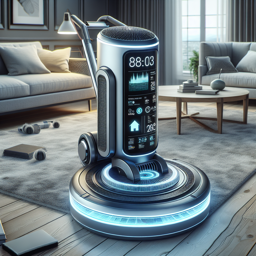

{
    'character_appearence': "An intelligent vacuum cleaner with a sleek, modern design. It's autonomous and 
futuristic.",
    'style_attributes': 'The style is photo-realistic with vivid, realistic reflections and shadows.',
    'worn_and_carried': 'The vacuum cleaner continues to have sensors activated and compartments are partially 
filled with captured dust.',
    'scenario': 'The vacuum is halfway through its cleaning in a more visibly clean room. Air quality has improved,
with real-time air quality indicators displayed on a smart screen.'
}

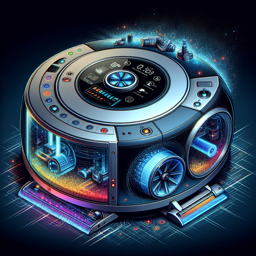

{
    'character_appearence': 'An intelligent vacuum cleaner polished and looking satisfied, symbolizing a job well 
done.',
    'style_attributes': 'The style remains photo-realistic with a focus on light play across surfaces for a sense 
of cleanliness.',
    'worn_and_carried': 'The vacuum cleaner has full dust compartments indicating a successful cleaning session.',
    'scenario': 'The living room is visibly spotless, and air quality indicators show optimal levels on the 
monitoring device post-cleaning.'
}

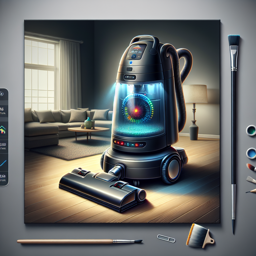

Enter your message, type 'APPROVE' to conclude the task: Approve


User:                                                       

Approve

In [24]:
runtime.start()
session_id = str(uuid.uuid4())
await runtime.publish_message(
    GroupChatMessage(
        body=UserMessage(
            content=messages,
            source="User",
        )
    ),
    TopicId(type=group_chat_topic_type, source=session_id),
)
await runtime.stop_when_idle()